# Modules & Functions

In [1]:
# import sys
import numpy as np
from scipy.stats import norm
import pandas as pd
import gc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, RectangleSkyRegion
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, MapDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, FoVBackgroundModel, Models, SmoothBrokenPowerLawSpectralModel
from gammapy.estimators import FluxPoints,FluxPointsEstimator, ExcessMapEstimator
%matplotlib inline
import sys, os
import numpy as np
import itertools
import re
import datetime
import gammapy
import time
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from matplotlib.gridspec import GridSpec
import json
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.stats import CashCountsStatistic, cash, cash_sum_cython
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore, Observations
from gammapy.datasets import Datasets, FluxPointsDataset, MapDatasetOnOff
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, DiskSpatialModel, TemplateSpatialModel, PowerLawNormSpectralModel, BrokenPowerLawSpectralModel
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion, EllipseSkyRegion
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
    EnergyDependentMorphologyEstimator)
# from common_utils import get_excluded_regions
#from gammapy.utils.regions import make_region
from gammapy.modeling.models import FoVBackgroundModel, GaussianSpatialModel, ShellSpatialModel, DiskSpatialModel, PiecewiseNormSpectralModel, GeneralizedGaussianSpatialModel, ExpCutoffPowerLawSpectralModel
from gammapy.makers import FoVBackgroundMaker
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator, FluxMaps
from gammapy.maps import WcsNDMap
from gammapy.visualization import plot_npred_signal, plot_distribution
import ipywidgets
from gammapy.modeling.models import Models
from astropy.coordinates import Angle
from collections import OrderedDict
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import datetime
from scipy.stats import chi2, norm
from astropy.table import Table
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import aplpy
import matplotlib.pyplot as mpl
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

DB_general = pd.read_csv('/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial/db_data.csv', header=0)
import sys  
sys.path.insert(1, '/home/hpc/caph/mppi103h/Documents/On-OFF-matching-woody')
from scipy.optimize import curve_fit
import common_utils
from common_utils import get_excluded_regions
from matplotlib.lines import Line2D
from PIL import Image
sys.path.insert(1, '/home/wecapstor1/caph/caph101h/projects/test_projects/HAWC_J0543+233/python_scripts/')
import my_utility_functions as muf
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.catalog import SourceCatalog4FGL
import os
import re
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy import table
import runmatching_utilities as util

In [2]:
PlotDir = "/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial/Plots/FOV/Hess_1u/Spectral/Background_estimation/"

In [3]:
def gaussian(x, amplitude, mean, stddev):
    """
    Gaussian function.
    
    Parameters:
    - x: Independent variable
    - amplitude: Peak value of the Gaussian
    - mean: Mean (center) of the Gaussian
    - stddev: Standard deviation (width) of the Gaussian
    
    Returns:
    - Gaussian function values
    """
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

def fit_gaussian(x_data, y_data):
    """
    Fits a Gaussian normal distribution to the given data.
    
    Parameters:
    - x_data: Array of x values
    - y_data: Array of y values
    
    Returns:
    - popt: Optimal values for the Gaussian parameters (amplitude, mean, stddev)
    - pcov: Covariance of the parameters
    """
    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [max(y_data), np.mean(x_data), np.std(x_data)]
    
    # Fit the Gaussian to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    error = np.diag(np.sqrt(pcov))
    return popt, error

In [4]:
def sexagesimal_to_ra_dec(ra_sexagesimal, dec_sexagesimal):
    """
    Converts RA and Dec from sexagesimal format (HH:MM:SS, DD:MM:SS) to decimal degrees.
    
    Parameters:
    - ra_sexagesimal: str
        Right Ascension in sexagesimal format (e.g., "07h00m28.8s").
    - dec_sexagesimal: str
        Declination in sexagesimal format (e.g., "+14d19m12.0s").

    Returns:
    - ra: float
        Right Ascension in decimal degrees.
    - dec: float
        Declination in decimal degrees.
    """
    # Create a SkyCoord object from sexagesimal inputs
    sky_coord = SkyCoord(ra=ra_sexagesimal, dec=dec_sexagesimal, frame='icrs')
    
    # Extract RA and Dec in decimal degrees
    ra = sky_coord.ra.deg
    dec = sky_coord.dec.deg
    
    return ra, dec

In [5]:
def plot_position(_ax_, ra, dec, name, _marker_):
    
    position = SkyCoord(ra, dec, frame='icrs', unit='deg')
    _ax_.text(position.ra.deg+.75, position.dec.deg+.05, name,color=_marker_['color'],transform=_ax_.get_transform('world'))
    _ax_.plot(position.ra.deg, position.dec.deg, **_marker_, transform=_ax_.get_transform('world'))

In [6]:
def find_energy_with_sensitivity(f_cubic, target_bias, initial_guess, delta_bias=0.01):  
    # Calculate energy for the target bias
    energy_found = fsolve(lambda x: f_cubic(x) - target_bias, initial_guess)[0]
    
    # Calculate energy for a slightly perturbed bias (plus and minus delta_bias)
    energy_high = fsolve(lambda x: f_cubic(x) - (target_bias + delta_bias), initial_guess)[0]
    energy_low = fsolve(lambda x: f_cubic(x) - (target_bias - delta_bias), initial_guess)[0]
    
    # The energy error is the half-range of energy found by perturbing the bias
    energy_error = abs(energy_high - energy_low) / 2
    
    return energy_found, energy_error

def energy_threshold_from_bias(_dataset_, _bias_percent_):
    # Obtain energy and bias data
    energy = np.array(_dataset_.edisp.get_edisp_kernel().axes["energy_true"].center)
    energy_min = _dataset_.energy_range_total[0].value
    bias = np.array(_dataset_.edisp.get_edisp_kernel().get_bias(energy))

    mask = (energy >= energy_min)
    x = energy[mask]
    y = bias[mask]

    # Create a cubic spline interpolation function with extrapolation
    f_cubic = interp1d(x, y, kind='cubic', fill_value='extrapolate')

    bias_energy_below_5_percent_low, error_low = find_energy_with_sensitivity(f_cubic, _bias_percent_*1e-2, initial_guess=.25)

    return bias_energy_below_5_percent_low, error_low 

# Loading data and plotting histograms

In [21]:
output_file_name_fits = '/home/vault/caph/caph101h/datasets/FOV/spectral/HESS1u/bkg_estimation/fits/simple_circle'
output_file_name_tilt_and_norm = '/home/vault/caph/caph101h/datasets/FOV/spectral/HESS1u/bkg_estimation/tilt_and_norm/simple_circle'
runs_spec = np.loadtxt('/home/vault/caph/caph101h/runlists/monogem/ON_OFF/runlists_monogem_Hess_1u_spectral.txt', usecols=(0,))

affected_runs = np.loadtxt('/home/vault/caph/caph101h/runlists/affected_runs/affected_runs.txt', usecols=(0,), dtype=float)

basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_flashcam_stereo/Monogem/out/'

ds = DataStore.from_dir(basedir,
                          'hdu-index-bg-3d-v07b-fov-radec.fits.gz',
                          'obs-index-bg-3d-v07b-fov-radec.fits.gz')

obs_list = ds.get_observations(runs_spec)



# Check for the runs that are in the store
runs_in_store = []
runs_not_in_store = []

for i in runs_spec:
    for obs, zenith in ds.obs_table["OBS_ID", "ZEN_PNT"]:
        if i == obs and zenith < 60:
            runs_in_store.append(i)
        else:
            runs_not_in_store.append(i)

obs_list = ds.get_observations(runs_in_store) 

# Filter out affected runs and collect unaffected runs
unaffected_runs = []
affected_runs_detected = []


runs_to_compare = [obs for obs in obs_list]
identical_numbers = muf.compare_arrays(runs_to_compare, affected_runs)

# Separate runs into affected and unaffected
for obs in obs_list:
    if obs.obs_id in identical_numbers:
        affected_runs_detected.append(obs.obs_id)
    else:
        unaffected_runs.append(obs.obs_id)

obs_list = ds.get_observations(unaffected_runs) 
run_list = [obs.obs_id for obs in obs_list]

print('Number of initial runs %.0f' %len(runs_spec))
print('Number of missing files %.0f' %len(runs_spec[runs_spec > np.max(ds.obs_table["OBS_ID"].value)]))
print('Number of contained runs %.0f' %(len(obs_list)))
print("Affected runs:", identical_numbers)

Number of initial runs 66
Number of missing files 0
Number of contained runs 66
Affected runs: []


In [22]:
periastron_years = [2003, 2009, 2014, 2020]

# Initialize lists to store good and bad observation dates
obs_id_date_bad = []
obs_id_date_good = []

for m in range(len(obs_list)):
    obs = obs_list[m]
    obs_id = obs.obs_id
    date_on = Time(obs.tmid.value, format='mjd')
    calendar_date_on = date_on.to_value('iso', subfmt='date')
    
    # Extract the year by slicing the first 4 characters of the date string
    obs_year = int(calendar_date_on[:4])
    
    # Check if the observation year coincides with any periastron year
    if (obs.gti.time_sum.value / 60) < 25:
        obs_id_date_bad.append(obs_id)
    else:
        obs_id_date_good.append(obs_id)


on_runs = [float(item) for item in obs_id_date_good]

In [23]:
output_file_name_fits = '/home/vault/caph/caph101h/datasets/FOV/spectral/HESS1u/bkg_estimation/fits/simple_circle'
output_file_name_tilt_and_norm = '/home/vault/caph/caph101h/datasets/FOV/spectral/HESS1u/bkg_estimation/tilt_and_norm/simple_circle'

basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_flashcam_stereo/Monogem/out'

ds = DataStore.from_dir(basedir,
                          'hdu-index-bg-3d-v07b-fov-radec.fits.gz',
                          'obs-index-bg-3d-v07b-fov-radec.fits.gz')

obs_list = ds.get_observations(on_runs)

print('Number of initial runs %.0f' %len(on_runs))
print('Number of contained runs %.0f' %(len(obs_list)))
print("Affected runs:", identical_numbers)

Number of initial runs 64
Number of contained runs 64
Affected runs: []


In [24]:
unique_coords = set()  # Store unique (ra, dec) pairs

for obs in obs_list:
    ra = round(obs.pointing.fixed_icrs.ra.value, 4)
    dec = round(obs.pointing.fixed_icrs.dec.value, 4)
    unique_coords.add((ra, dec))

print(unique_coords)

{(104.95, 15.9386), (104.95, 12.5386), (106.55, 14.2386), (103.35, 14.2386)}


In [25]:
ra_obj = 105.12 
dec_obj = 14.32
target = SkyCoord(ra_obj, dec_obj, frame='icrs', unit='deg')

e_reco = np.logspace(-1, 2, 25) * u.TeV 
e_true = np.logspace(-1, 2, 50) * u.TeV 

energy_axis = MapAxis.from_edges(e_reco, unit='TeV', name='energy', interp='log')
energy_axis_true = MapAxis.from_edges(e_true, unit='TeV', name="energy_true", interp='log')

FoV_width = 8
binsz = 0.01
# maximal offset from pointing centre of observation
max_offset = 2 * u.deg

geom = WcsGeom.create(
    skydir=(ra_obj, dec_obj),
    binsz=binsz,
    width=(FoV_width,FoV_width),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis])

In [26]:
indices = np.where(np.isin(ds.obs_table['OBS_ID'], on_runs))
zenith_angles = ds.obs_table['ZEN_PNT'][indices]
livetime = ds.obs_table['LIVETIME'][indices] / 3600
livetime_min = ds.obs_table['LIVETIME'][indices] / 60

mean_zenith_angle = np.mean(zenith_angles)
std_zenith_angle =  np.std(zenith_angles)
total_livetime = np.sum(livetime)
run_num = len(obs_list)
mean_livetime = np.mean(livetime) 
std_livetime = np.std(livetime)

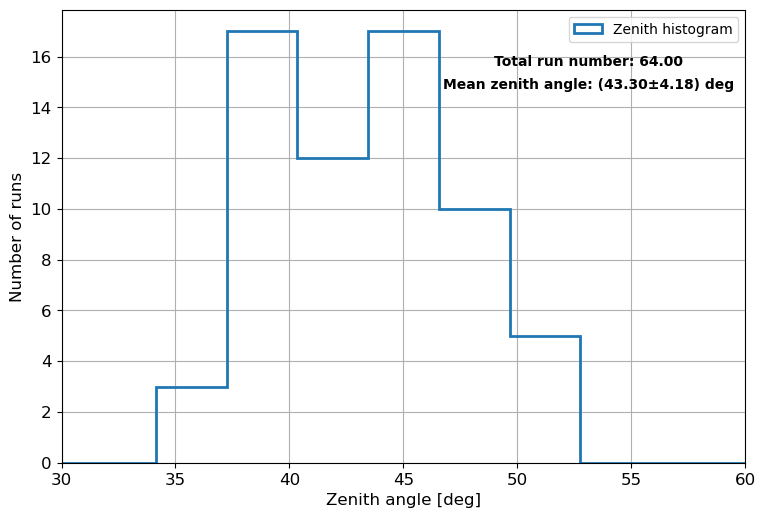

In [27]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3)  

ax1 = plt.subplot(gs[0, 0])

ax1.hist(zenith_angles, bins=np.linspace(0, 90, 30), histtype='step', lw=2, label = 'Zenith histogram')

ax1.text(.77, 0.9, f'Total run number: {run_num:.2f}', ha='center', va='top', transform=ax1.transAxes,
        fontsize=10, color='black', fontweight='bold')
ax1.text(.77, 0.85, f'Mean zenith angle: ({mean_zenith_angle:.2f}±{std_zenith_angle:.2f}) deg', ha='center', va='top', transform=ax1.transAxes,
        fontsize=10, color='black', fontweight='bold')
ax1.grid()
ax1.set_xlim(30, 60)
ax1.legend()

ax1.tick_params(axis='both', which='major', labelsize=12)  # Increase the tick size for major ticks
ax1.tick_params(axis='both', which='minor', labelsize=12)  # Optionally adjust for minor ticks

ax1.set_xlabel('Zenith angle [deg]', fontsize=12)  # Increase x-axis label size
ax1.set_ylabel('Number of runs', fontsize=12)     # Increase y-axis label size

# muf.save_figures(PlotDir, name = 'monogem_zenith_histogram')

plt.show()

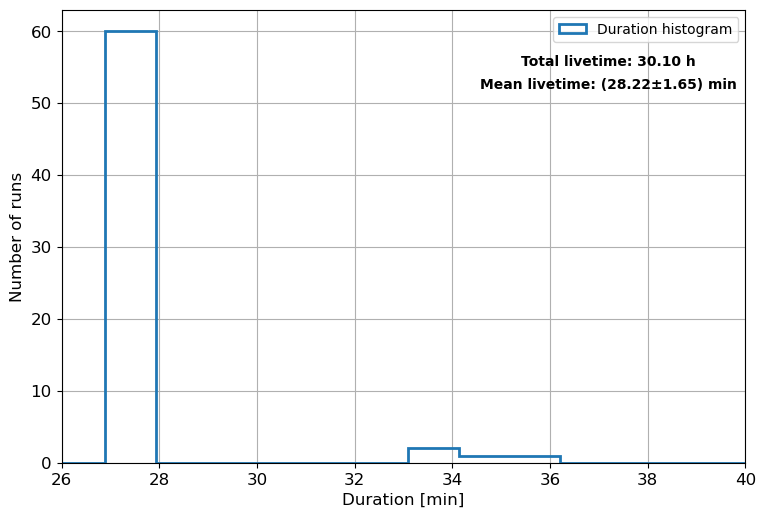

In [28]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3)  

ax1 = plt.subplot(gs[0, 0])
ax1.hist(livetime_min, bins=np.linspace(0, 60, 59), histtype='step', lw=2, label = 'Duration histogram')
ax1.text(.8, 0.9, f'Total livetime: {total_livetime:.2f} h', ha='center', va='top', transform=ax1.transAxes, fontsize=10, color='black', fontweight='bold')
ax1.text(.8, 0.85, f'Mean livetime: ({mean_livetime*60:.2f}±{std_livetime*60:.2f}) min', ha='center', va='top', transform=ax1.transAxes, fontsize=10, color='black', fontweight='bold')
ax1.set_xlabel('Duration [min]', fontsize=12)
ax1.set_ylabel('Number of runs', fontsize=12)
ax1.grid()
ax1.set_xlim(26, 40)
ax1.legend()

ax1.tick_params(axis='both', which='major', labelsize=12)  # Increase the tick size for major ticks
ax1.tick_params(axis='both', which='minor', labelsize=12)  # Optionally adjust for minor ticks


muf.save_figures(PlotDir, name = 'monogem_livetime_histogram')

plt.show()

In [29]:
database_path_woody = '/home/wecapstor1/caph/shared/hess/fits/database_image'
DB_trigger = pd.read_csv('{}/trigger_1223.csv'.format(database_path_woody))
DB_pix = pd.read_csv('{}/pixel_1223.csv'.format(database_path_woody))
DB_track = pd.read_csv('{}/tracking_1223.csv'.format(database_path_woody))
DB_atmo = pd.read_csv('{}/atmosphere_1223.csv'.format(database_path_woody))
DB_weather = pd.read_csv('{}/weather_1223.csv'.format(database_path_woody))
DB_muon = pd.read_csv('{}/muon_1223.csv'.format(database_path_woody), low_memory=False)
DB_header = pd.read_csv('{}/header_1223.csv'.format(database_path_woody))
DB_ADC = pd.read_csv('{}/ADC_1223.csv'.format(database_path_woody))
monitor_run_data = pd.read_csv('{}/data_1223.csv'.format(database_path_woody)).sort_values("Run", ascending=True)
DB_radio = pd.read_csv('{}/radiometer_1223.csv'.format(database_path_woody))

In [30]:
temp_df = DB_weather[np.isin(DB_weather["Run"], on_runs)]


atmospheric_df = DB_atmo[np.isin(DB_atmo["Run"], on_runs)]

muon_df = DB_muon[np.isin(DB_muon["Run"], on_runs)]
muon_df = muon_df.groupby("Run", as_index=False)["Efficiency_mean"].mean()

trigger_df = DB_trigger[np.isin(DB_trigger["Run"], on_runs)]
trigger_df = trigger_df.groupby("Run", as_index=False)["True_Rate_mean"].mean()

nsb_df = DB_pix[np.isin(DB_pix["Run"], on_runs)]
mean_nsb_df = nsb_df.groupby("Run", as_index=False)["Ped_NSB_mean"].mean()
mean_nsb_df.rename(columns={"Ped_NSB_mean": "Mean_NSB"}, inplace=True)

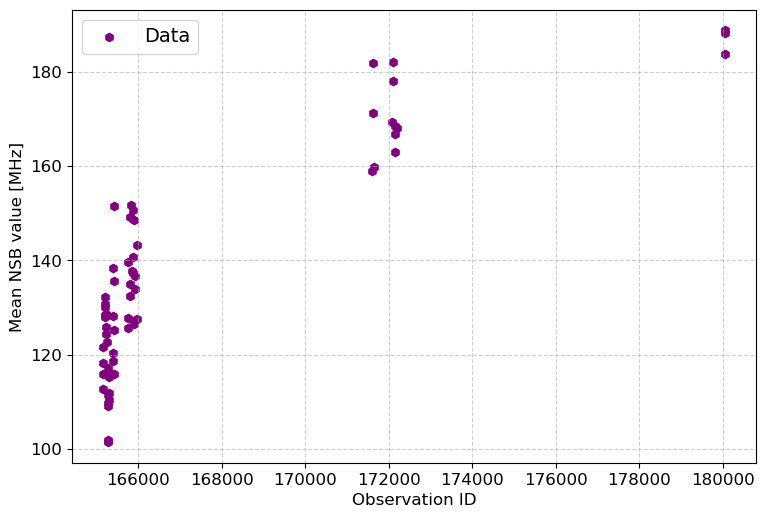

In [31]:
# Create a figure and specify the size
plt.figure(figsize=(30, 20))

# Define the GridSpec layout
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])

# # First subplot: Atmospheric Transparency Coefficient
# ax1 = plt.subplot(gs[0, 0])
# ax1.scatter(atmospheric_df["Run"], atmospheric_df["TransparencyCoefficient_mean"], color='blue', marker='o', label="Data")
# ax1.set_xlabel("Observation ID", fontsize=16)
# ax1.set_ylabel("Mean Transparency Coefficient", fontsize=16)
# ax1.grid(True, linestyle='--', alpha=0.6)
# ax1.legend(fontsize=14)

# Second subplot: Muon Efficiency
# ax2 = plt.subplot(gs[0, 1])
# ax2.scatter(muon_df["Run"], muon_df["Efficiency_mean"], color='green', marker='^', label="Data")
# ax2.set_ylabel("Mean Muon Efficiency", fontsize=16)
# ax2.set_xlabel("Observation ID", fontsize=16)
# ax2.grid(True, linestyle='--', alpha=0.6)
# ax2.legend(fontsize=14)

# ax3 = plt.subplot(gs[1, 0])
# ax3.scatter(trigger_df["Run"], trigger_df["True_Rate_mean"], color='red', marker='x', label="Data")
# ax3.set_ylabel("Mean trigger rate", fontsize=16)
# ax3.set_xlabel("Observation ID", fontsize=16)
# ax3.grid(True, linestyle='--', alpha=0.6)
# ax3.legend(fontsize=14)

ax4 = plt.subplot(gs[1, 1])
ax4.scatter(mean_nsb_df["Run"], mean_nsb_df["Mean_NSB"], color='purple', marker='h', label="Data")
# ax4.set_title("Mean NSB over runs", fontsize=20)
ax4.set_xlabel("Observation ID", fontsize=12)
ax4.set_ylabel("Mean NSB value [MHz]", fontsize=12)
ax4.grid(True, linestyle='--', alpha=0.6)
ax4.legend(fontsize=14)

ax4.tick_params(axis='both', which='major', labelsize=12)  # Increase the tick size for major ticks
ax4.tick_params(axis='both', which='minor', labelsize=12)  # Optionally adjust for minor ticks

# ax5 = plt.subplot(gs[2, 0])
# ax5.scatter(temp_df["Run"], temp_df["AirTemperature_mean"], color='orange', marker='v', label="Data")
# ax5.set_xlabel("Observation ID", fontsize=16)
# ax5.set_ylabel("Mean Temperature value [°C]", fontsize=16)
# ax5.grid(True, linestyle='--', alpha=0.6)
# ax5.legend(fontsize=14)



# Display the plot
# plt.tight_layout(rect=[0, 0, 1, 0.93])

# muf.save_figures(PlotDir, name='nsb_histogram_before_duration_leftouts')

plt.show()

# Background reduction process

In [54]:
hap_exclusion_regions = get_excluded_regions(ra_obj, dec_obj, 5)
excl_regions = []
for source in hap_exclusion_regions:
    center = SkyCoord(source.ra, source.dec, unit = 'deg', frame = 'icrs')
    area = CircleSkyRegion(center=center, radius=source.radius*u.deg)
    name = source.name
    print(name)
    excl_regions.append(area)

target = SkyCoord(ra_obj, dec_obj, frame='icrs', unit='deg')
region_source = CircleSkyRegion(center=target, radius=2*u.deg)

excl_regions.append(region_source)


excl_regions_mask = geom.region_mask(regions=excl_regions, inside=False)
excl_regions_mask_map = Map.from_geom(geom=geom, data=excl_regions_mask.data)

HIP_32362
HIP_35350


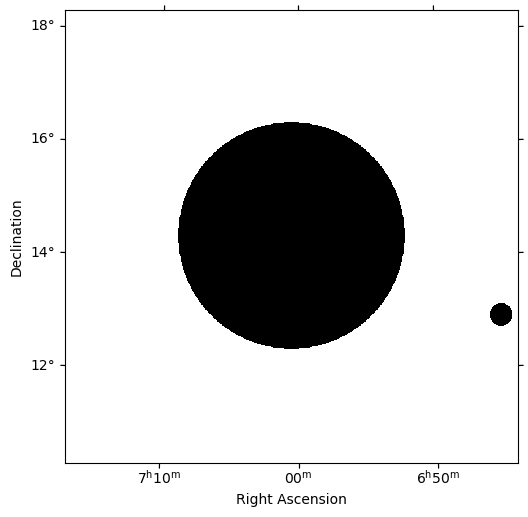

In [33]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
ax1 = plt.subplot(gs[0, 0], projection=excl_regions_mask.geom.wcs)

excl_regions_mask.sum_over_axes().plot(ax=ax1)
# muf.save_figures(PlotDir, name="monogem_exclusion_masks")
plt.show()

In [34]:
max_offset = 2*u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'aeff-default', 'aeff-max', 'bkg-peak', 'edisp-bias'], offset_max=max_offset)
stacked_name = 'stacked_monogem_fov'
stacked = MapDataset.create(geom=geom, name=stacked_name, energy_axis_true=energy_axis_true)

tilt_vals = []
norm_vals = []    
    
for m in range(len(obs_list)):
    print(f'{m+1} of {len(obs_list)} runs to analyse')
    obs = obs_list[m]
    obs_id = obs.obs_id
    
    cutout = stacked.cutout(obs.pointing.fixed_icrs, width=2*max_offset, name = f"obs-{obs.obs_id}")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    
    maker_fov_bkg = FoVBackgroundMaker(method="fit", exclusion_mask=excl_regions_mask_map) 
    bkg_model_on = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = bkg_model_on
    dataset.background_model.spectral_model.norm.frozen = False
    dataset.background_model.spectral_model.tilt.frozen = False
    dataset = maker_fov_bkg.run(dataset)
    
    tilt_vals.append(dataset.background_model.spectral_model.tilt.value)
    norm_vals.append(dataset.background_model.spectral_model.norm.value)
    
    stacked.stack(dataset)   

1 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


2 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


3 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


4 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


5 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


6 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


7 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


8 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


9 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


10 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


11 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


12 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


13 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


14 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


15 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


16 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


17 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


18 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


19 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


20 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


21 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


22 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


23 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


24 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


25 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


26 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


27 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


28 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


29 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


30 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


31 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


32 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


33 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


34 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


35 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


36 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


37 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


38 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


39 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


40 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


41 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


42 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


43 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


44 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


45 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


46 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


47 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


48 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


49 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


50 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


51 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


52 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


53 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


54 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


55 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


56 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


57 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


58 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


59 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


60 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


61 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


62 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


63 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


64 of 64 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


In [35]:
# stacked.write('/home/vault/caph/caph101h/datasets/FOV/spectral/HESS1u/bkg_estimation/fits/stacked_monogem.fits.gz', overwrite=True)

[16.661245066048252, -0.02004274839768337, 0.11252131797427832]
[0.9087320686107322, 0.007086691722380595, 0.007086692782093094]


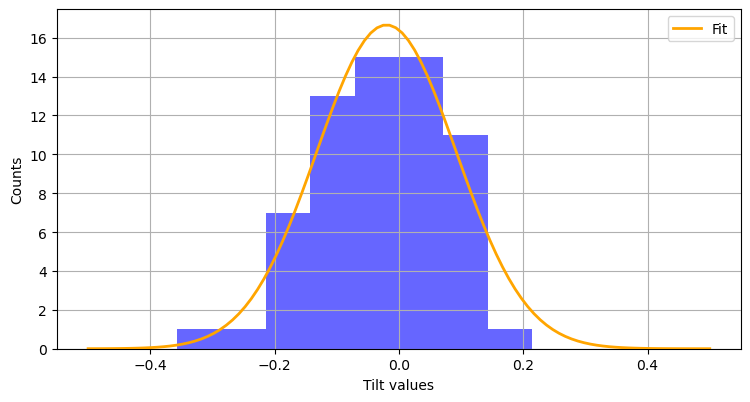

In [36]:
plt.figure(figsize=(30, 15))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
ax1 = plt.subplot(gs[0, 0])

# Tilt data
tilt_vals = tilt_vals
bins_tilt_hist = np.linspace(-.5, .5, 15)
n_tilt, bins_tilt, _ = ax1.hist(tilt_vals, bins=bins_tilt_hist, color='blue', alpha=0.6, lw=2, zorder=1)
x_vals_tilt = 0.5 * (bins_tilt[:-1] + bins_tilt[1:])

x = np.linspace(-.5, .5, 100)
fit, error = fit_gaussian(x_vals_tilt, n_tilt)
print([item for item in fit])
print([item for item in error])

ax1.plot(x, gaussian(x, *fit), lw=2, color='orange', ls='solid', zorder=4,label=r"Fit")
ax1.set_xlabel('Tilt values')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.grid()

muf.save_figures(PlotDir, name='monogem_tilt_histogram')

plt.show()

[34.291470613153955, 1.0885749096738795, 0.09935460915610543]
[0.9075757366695684, 0.0035045504720917367, 0.0028706873737992756]


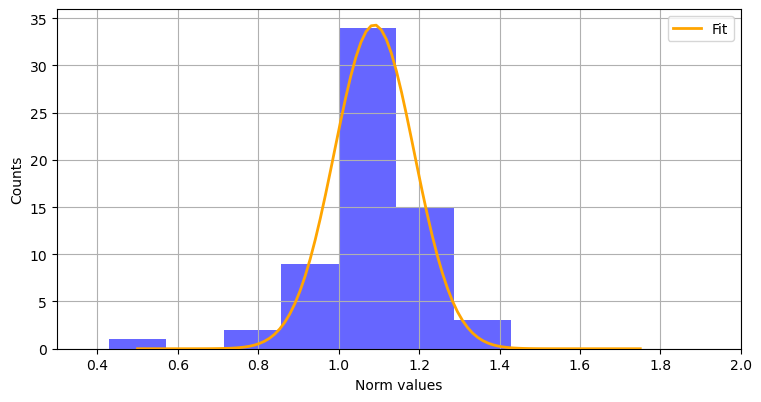

In [104]:
plt.figure(figsize=(30, 15))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
ax2 = plt.subplot(gs[0, 0])

# Norm data
norm_vals = norm_vals
bins_norm_hist = np.linspace(0, 2, 15)
n_norm, bins_norm, _ = ax2.hist(norm_vals, bins=bins_norm_hist, color='blue', alpha=0.6, lw=2, zorder=1)
x_vals_norm = 0.5 * (bins_norm[:-1] + bins_norm[1:])

x = np.linspace(.5, 1.75, 100)
fit, error = fit_gaussian(x_vals_norm, n_norm)
print([item for item in fit])
print([item for item in error])

ax2.plot(x, gaussian(x, *fit), lw=2, color='orange', ls='solid', zorder=4,label=r"Fit")

ax2.set_xlabel('Norm values')
ax2.set_ylabel('Counts')
ax2.legend()
ax2.grid(zorder=0)
ax2.set_xlim(.3, 2)
# 
# muf.save_figures(PlotDir, name='monogem_norm_histogram')

plt.show()

# Plotting

In [8]:
stacked = MapDataset.read('/home/vault/caph/caph101h/datasets/FOV/spectral/HESS1u/bkg_estimation/fits/stacked_monogem.fits.gz')

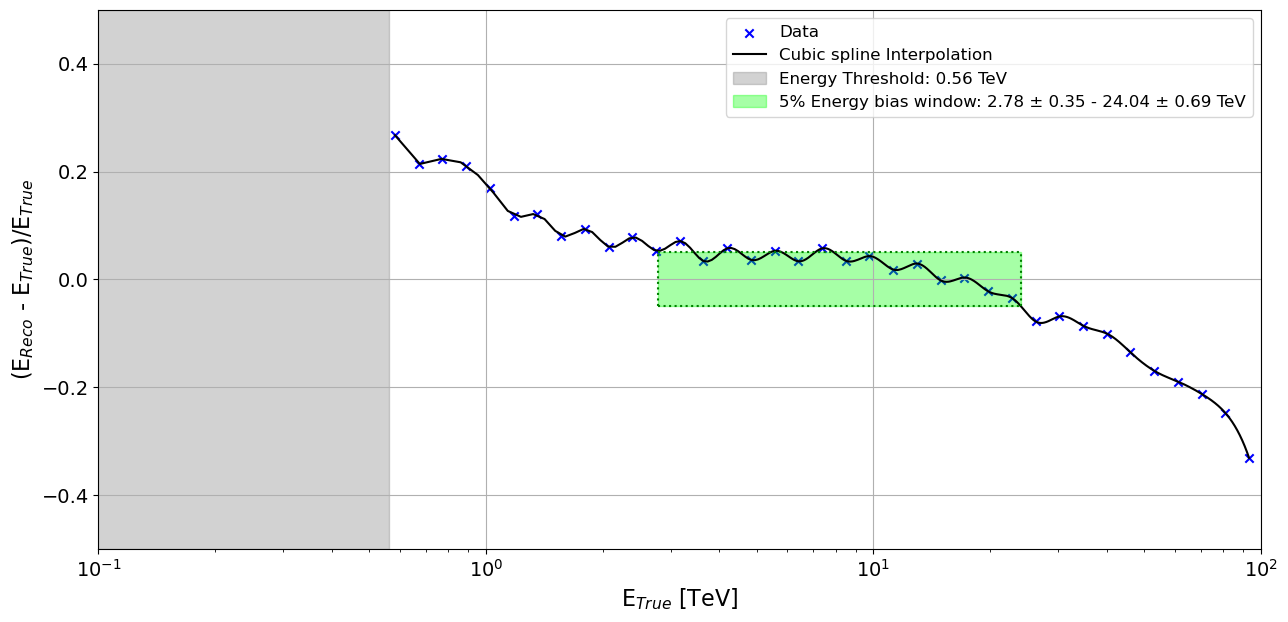

In [9]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.misc import derivative  # Import derivative for error propagation

bias_percent = 5

# Obtain energy and bias data
energy = np.array(stacked.edisp.get_edisp_kernel().axes["energy_true"].center)
energy_min = stacked.energy_range_total[0].value
bias = np.array(stacked.edisp.get_edisp_kernel().get_bias(energy))

mask = (energy >= energy_min)

# Filtered data
x = energy[mask]
y = bias[mask]

# Create a cubic spline interpolation function with extrapolation
f_cubic = interp1d(x, y, kind='cubic', fill_value='extrapolate')

# Find energies and errors for bias 0.05 and bias 0
bias_energy_below_5_percent_low, error_low = find_energy_with_sensitivity(f_cubic, bias_percent*1e-2, initial_guess=0.5)
bias_energy_below_5_percent_high, error_high = find_energy_with_sensitivity(f_cubic, -bias_percent*1e-2, initial_guess=49)

# Plotting
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))

# Scatter plot of bias data
ax1.scatter(x, y, marker ='x', label='Data', color='blue')

# Interpolation plot
x_new = np.linspace(min(x), max(x), 1000)
y_new = f_cubic(x_new)
ax1.plot(x_new, y_new, label='Cubic spline Interpolation', color='black')

# Energy threshold area
ax1.axvspan(xmin=0, xmax=stacked.energy_range_total[0].value, color='grey', alpha=.35, label=f'Energy Threshold: {round(stacked.energy_range_total[0].value, 2)} TeV')

# Vertical lines for bias energy thresholds
ax1.vlines(bias_energy_below_5_percent_low, -bias_percent*1e-2, bias_percent*1e-2, ls=':', color='green')
ax1.vlines(bias_energy_below_5_percent_high, -bias_percent*1e-2, bias_percent*1e-2, ls=':', color='green')

# Horizontal lines for bias threshold
ax1.hlines(bias_percent*1e-2, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high, ls=':', color='green')
ax1.hlines(-bias_percent*1e-2, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high, ls=':', color='green')

# Label for the bias window
label_box = (f'{bias_percent}% Energy bias window: {round(bias_energy_below_5_percent_low, 2)} ± {round(error_low, 2)} - 'f'{round(bias_energy_below_5_percent_high, 2)} ± {round(error_high, 2)} TeV')
ax1.axvspan(xmin=bias_energy_below_5_percent_low, xmax=bias_energy_below_5_percent_high, ymin=0.45, ymax=.55, color='lime', alpha=.35, label=label_box)

# Set limits and labels
ax1.set_xlim(1e-1, 1e2)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('E$_{True}$ [TeV]', fontsize=16)
ax1.set_ylabel(r'(E$_{Reco}$ - E$_{True}$)/E$_{True}$', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid()
ax1.set_xscale('log')

ax1.tick_params(axis='both', which='major', labelsize=14)  # Increase the tick size for major ticks
ax1.tick_params(axis='both', which='minor', labelsize=14)  # Optionally adjust for minor ticks


# Save the figure if needed
# muf.save_figures(PlotDir, name='monogem_bias_stacked_dataset')

plt.show()

In [10]:
Excess_map_estimator = ExcessMapEstimator(correlation_radius=.6*u.deg,energy_edges=[.1, 100] * u.TeV)
result = Excess_map_estimator.run(stacked)
significance_map = result.sqrt_ts

plt.show()

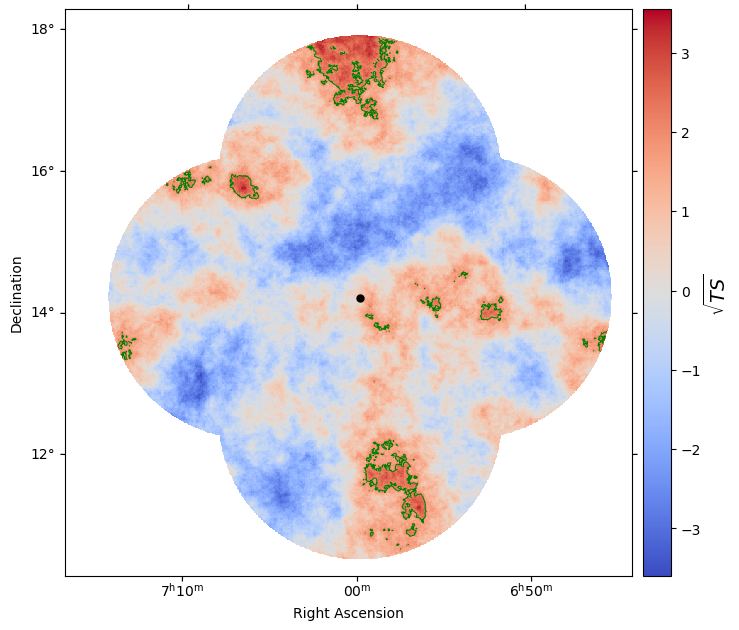

In [16]:
color = ['green']
sigma_level = [2]
significance_array = np.squeeze(significance_map)
contour_legend = Line2D([0], [0], color=color[0], label=rf'{sigma_level[0]}$\sigma$')

plt.figure(figsize=(30, 25))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
################################################################################################################################
ax1 = plt.subplot(gs[0, 0], projection=significance_map.geom.wcs)

significance_map.plot(ax=ax1, add_cbar=True, cmap='coolwarm')

ax1.contour(significance_array, levels=sigma_level, colors=color, linewidths = .75)

marker_psr = dict(marker='o', color='black', markersize=5)
plot_position(ax1, 104.95, 14.24, '', marker_psr) # PSR J1028-5819

ax1.text(99.75, 14.24, r"$\sqrt{TS}$", color='black', transform=ax1.get_transform('world'), rotation=90, ha='center', va='center', fontsize=14, weight='bold')

muf.save_figures(PlotDir, name="monogem_sqrt_ts_map")

plt.show()

[12566.153693559207, -0.024020724002328363, 1.3304353314153472]
[130.73865176824566, 0.01598318568213187, 0.015983186648121924]


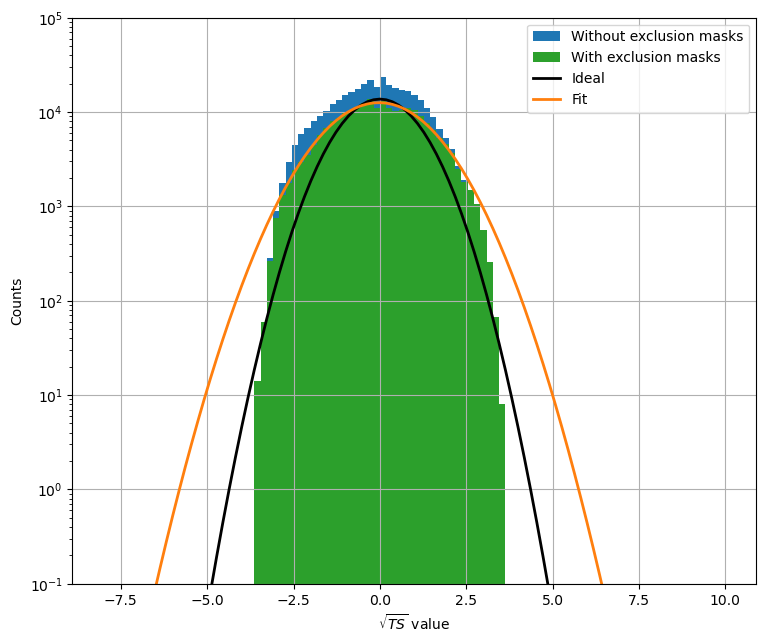

In [44]:
plt.figure(figsize=(30, 25))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  

ax2 = plt.subplot(gs[0,1])
excl_data = significance_map.geom.region_mask(regions=excl_regions, inside=False)
significance_map_excl = significance_map * excl_data
significance_data_excl = significance_map_excl.data[np.isfinite(significance_map_excl.data)]
significance_map_excl.data[~excl_data] = np.nan
significance_data = significance_map_excl.data[np.isfinite(significance_map_excl.data)]

significance_data_no_exclusion = significance_map.data[np.isfinite(significance_map.data)]

bins = np.linspace(-8, 10, 100)
ax2.hist(significance_data_no_exclusion, bins=bins, color='tab:blue', alpha=1, lw=2, zorder=0, label="Without exclusion masks")
n, bins_, _ = ax2.hist(significance_data, bins=bins, color='tab:green', alpha=1, lw=2, zorder=1, label="With exclusion masks")
x_vals = 0.5 * (bins_[:-1] + bins_[1:])
mu, std = norm.fit(significance_data)
y = norm.pdf(x_vals, mu, std) * sum(n * np.diff(bins_))

y_theo = gaussian(bins, np.max(n), 0, 1)#norm.pdf(x_vals, 0, 1) * sum(n * np.diff(bins_))


fit, error = fit_gaussian(x_vals, n)
print([item for item in fit])
print([item for item in error])

# ax2.plot(x_vals, y, lw=2, color="black",label=r"Fit".format(mu, std))
ax2.plot(bins, y_theo, lw=2,color="black", label=r"Ideal")
ax2.plot(bins, gaussian(bins, *fit), lw=2, color="tab:orange", label='Fit')

ax2.legend()
#ax2.set_xlim(-5, 5)
ax2.set_ylim(1e-1, 1e5)
ax2.set_xlabel(r'$\sqrt{TS}$ value')
ax2.set_ylabel('Counts')
ax2.grid()

ax2.set_yscale('log')

muf.save_figures(PlotDir, name='monogem_sqrt_ts_map_histogram')

plt.show()